### ROLL NO:M22AI567
## Deep Learning  ---   Programming Assignment 3                            


### Implement the Sparse auto-encoders (AE). Use the MNIST digit dataset for training your network. Perform the k-means clustering on the embeddings. To evaluate the performance of the k-means algorithm

## Sparse Autoencoders for MNIST classification

In [1]:
%matplotlib inline
import copy
import torch
import numpy as np
import torchvision
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

print(torch.__version__) # This code has been updated for PyTorch 1.0.0

2.0.1+cpu


In [2]:
transform = transforms.Compose([transforms.ToTensor()])
BatchSize = 1000

trainset = torchvision.datasets.MNIST(root='./MNIST', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BatchSize,
                                          shuffle=True, num_workers=4) # Creating dataloader

testset = torchvision.datasets.MNIST(root='./MNIST', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BatchSize,
                                         shuffle=False, num_workers=4) # Creating dataloader

classes = ('zero', 'one', 'two', 'three',
           'four', 'five', 'six', 'seven', 'eight', 'nine')

In [3]:
# Check availability of GPU

use_gpu = torch.cuda.is_available()
if use_gpu:
    print('GPU is available!')
    device = "cuda"
else:
    print('GPU is not available!')
    device = "cpu"

GPU is not available!


 ## Sparse Autoencoder:

In [4]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 400),
            nn.Tanh())
        self.decoder = nn.Sequential(
            nn.Linear(400, 28*28),
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)        
        x = self.decoder(x)
        return x


net = autoencoder()
print(net)

net = net.to(device)

init_weightsE = copy.deepcopy(net.encoder[0].weight.data)
init_weightsD = copy.deepcopy(net.decoder[0].weight.data)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Tanh()
  )
  (decoder): Sequential(
    (0): Linear(in_features=400, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


# Train Autoencoder:

In [5]:
iterations = 20 # >10
learning_rate = 10
lambda1 = 0.1 # sparsity factor
criterion = nn.MSELoss()

dataiter = next(iter(testloader))
test_images, test_labels = dataiter
printImg = torch.Tensor(int(iterations/10),2,1,28,28)

for epoch in range(iterations):  # loop over the dataset multiple times
    runningLoss = 0.0
    net.train()
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28*28).to(device)
        net.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, inputs) # calculate loss
        l1_norm = lambda1*torch.norm(net.encoder[0].weight, p=1) # L1 penalty for the encoder
        total_loss = loss+l1_norm        
        total_loss.backward() #  backpropagate the loss
        for f in net.parameters():
            f.data.sub_(f.grad.data * learning_rate) # weight = weight - learning_rate * gradient (Update Weights)
        runningLoss += loss.item()
        
    print('At Iteration : %d / %d  ;  Mean-Squared Error : %f'%(epoch + 1,iterations,
                                                                        runningLoss/(60000/BatchSize)))
    
    if epoch%10 == 0:
        net.eval()
        with torch.no_grad():
            outImg = net((test_images[0].view(-1,28*28).to(device))).data
            outImg = outImg.view(-1,28,28)
            if use_gpu:
                outImg = outImg.cpu()   

            dispImg = torch.Tensor(2,1,28,28)
            dispImg[0] = test_images[0]
            dispImg[1] = outImg
            printImg[int(epoch/10)] = dispImg
print('Finished Training')

At Iteration : 1 / 20  ;  Mean-Squared Error : 0.262892
At Iteration : 2 / 20  ;  Mean-Squared Error : 0.251907
At Iteration : 3 / 20  ;  Mean-Squared Error : 0.212407
At Iteration : 4 / 20  ;  Mean-Squared Error : 0.187286
At Iteration : 5 / 20  ;  Mean-Squared Error : 0.167179
At Iteration : 6 / 20  ;  Mean-Squared Error : 0.144206
At Iteration : 7 / 20  ;  Mean-Squared Error : 0.132183
At Iteration : 8 / 20  ;  Mean-Squared Error : 0.121499
At Iteration : 9 / 20  ;  Mean-Squared Error : 0.114485
At Iteration : 10 / 20  ;  Mean-Squared Error : 0.111406
At Iteration : 11 / 20  ;  Mean-Squared Error : 0.102597
At Iteration : 12 / 20  ;  Mean-Squared Error : 0.099579
At Iteration : 13 / 20  ;  Mean-Squared Error : 0.096747
At Iteration : 14 / 20  ;  Mean-Squared Error : 0.094058
At Iteration : 15 / 20  ;  Mean-Squared Error : 0.089793
At Iteration : 16 / 20  ;  Mean-Squared Error : 0.086193
At Iteration : 17 / 20  ;  Mean-Squared Error : 0.087659
At Iteration : 18 / 20  ;  Mean-Squared 

In [6]:
# functions to show an image
def imshow(img, strlabel):
    npimg = img.numpy()
    npimg = np.abs(npimg)
    fig_size = plt.rcParams["figure.figsize"]
    fig_size[0] = 10
    fig_size[1] = 10
    plt.rcParams["figure.figsize"] = fig_size
    plt.figure()
    plt.title(strlabel)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## Modifying the autoencoder for classification:

In [7]:
# Removing the decoder module from the autoencoder
new_classifier = nn.Sequential(*list(net.children())[:-1])
net = new_classifier
# Adding linear layer for 10-class classification problem
net.add_module('classifier', nn.Sequential(nn.Linear(400, 10),nn.LogSoftmax(dim=1)))
print(net)
net = net.to(device)

Sequential(
  (0): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): Tanh()
  )
  (classifier): Sequential(
    (0): Linear(in_features=400, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)


# Train Classifier:

In [8]:
iterations = 10
learning_rate = 0.1
criterion = nn.NLLLoss()

for epoch in range(iterations):  # loop over the dataset multiple times

    runningLoss = 0.0
    net.train()
    for data in trainloader:
        # get the inputs
        inputs, labels = data
        
        inputs, labels = inputs.view(-1, 28*28).to(device), labels.to(device)

        net.zero_grad()  # zeroes the gradient buffers of all parameters
        outputs = net(inputs) # forward 
        loss = criterion(outputs, labels) # calculate loss
        loss.backward() #  backpropagate the loss
        for f in net.parameters():
            f.data.sub_(f.grad.data * learning_rate) # weight = weight - learning_rate * gradient (Update Weights)
        runningLoss += loss.item()
        correct = 0
        total = 0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            inputs, labels = inputs.view(-1, 28*28).to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum()
    print('At Iteration : %d / %d  ;  Train Error : %f ;Test Accuracy : %f'%(epoch + 1,iterations,
                                                                        runningLoss/(60000/BatchSize),100 * float(correct) /float(total)))
print('Finished Training')

At Iteration : 1 / 10  ;  Train Error : 2.456811 ;Test Accuracy : 55.420000
At Iteration : 2 / 10  ;  Train Error : 1.119022 ;Test Accuracy : 68.910000
At Iteration : 3 / 10  ;  Train Error : 0.707241 ;Test Accuracy : 77.330000
At Iteration : 4 / 10  ;  Train Error : 0.510065 ;Test Accuracy : 86.570000
At Iteration : 5 / 10  ;  Train Error : 0.410135 ;Test Accuracy : 89.710000
At Iteration : 6 / 10  ;  Train Error : 0.371824 ;Test Accuracy : 90.440000
At Iteration : 7 / 10  ;  Train Error : 0.346546 ;Test Accuracy : 90.880000
At Iteration : 8 / 10  ;  Train Error : 0.327358 ;Test Accuracy : 91.440000
At Iteration : 9 / 10  ;  Train Error : 0.312980 ;Test Accuracy : 91.720000
At Iteration : 10 / 10  ;  Train Error : 0.301483 ;Test Accuracy : 92.070000
Finished Training


 # Performance of different Classes:

In [9]:
class_correct = np.zeros(10)
class_total = np.zeros(10)
net.eval()

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.view(-1, 28*28).to(device))
        _, predicted = torch.max(outputs.data, 1)
        if use_gpu:
            predicted = predicted.cpu()        
        c = (predicted == labels).squeeze(0)        
        for i in range(images.shape[0]):
            label = labels[i]                            
            class_correct[label] += float(c[i])
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %f %%' % (
        classes[i], 100 * float(class_correct[i]) / float(class_total[i])))

Accuracy of  zero : 98.061224 %
Accuracy of   one : 97.621145 %
Accuracy of   two : 90.116279 %
Accuracy of three : 91.287129 %
Accuracy of  four : 93.584521 %
Accuracy of  five : 85.313901 %
Accuracy of   six : 93.945720 %
Accuracy of seven : 92.315175 %
Accuracy of eight : 89.117043 %
Accuracy of  nine : 88.107037 %


# Perform the k-means clustering 

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
import urllib
import struct
import time
import gzip
import os

In [11]:
# activation function
def sigmoid_function(signal, derivative=False):
    if derivative:
        # Return the partial derivation of the activation function
        return np.multiply(signal, 1.0 - signal)
    else:
        # Return the activation signal
        return 1.0 / (1.0 + np.exp(-signal))


def ReLU_function(signal, derivative=False):
    if derivative:
        return (signal > 0).astype(float)
    else:
        # Return the activation signal
        return np.maximum(0, signal)


def tanh_function(signal, derivative=False):
    # Calculate activation signal
    if derivative:
        # Return the partial derivation of the activation function
        return 1 - np.power(signal, 2)
    else:
        # Return the activation signal
        return np.tanh(signal)


def softmax_function(signal):
    # Calculate activation signal
    e_x = np.exp(signal - np.max(signal, axis=1, keepdims=True))
    signal = e_x / np.sum(e_x, axis=1, keepdims=True)
    return signal

# end activation function

In [12]:
def subtract_err(outputs, targets):
    res = outputs - targets
    return res


def mse(outputs, targets):
    res = np.power(outputs - targets, 2)
    return res


def cross_entropy_cost(outputs, targets):
    epsilon = 1e-11
    targets = np.clip(targets, epsilon, 1 - epsilon)
    return -np.mean(outputs * np.log(targets) + (1 - outputs) * np.log(1 - targets))


In [13]:
class LinearLayer:
    """The linear layer performs a linear transformation to its input."""

    def __init__(self, name, n_in, n_out, activation=sigmoid_function):
        self.name = name
        self.activation = activation
        self.result = []

        self.weights = 2 * np.random.random((n_in, n_out)) - 1
        self.biases = np.zeros(n_out)

    def get_output(self, x):
        result = self.activation(x.dot(self.weights) + self.biases)
        self.result = result
        return result


In [14]:

class SparseLayer(LinearLayer):

    def __init__(self, name, n_in, n_out, activation=sigmoid_function, num_k_sparse=10):
        LinearLayer.__init__(self, name, n_in, n_out, activation)
        self.num_k_sparse = num_k_sparse

    def get_output(self, x):
        result = self.activation(x.dot(self.weights) + self.biases)

        k = self.num_k_sparse
        if k < result.shape[1]:
            for raw in result:
                indices = np.argpartition(raw, -k)[-k:]
                mask = np.ones(raw.shape, dtype=bool)
                mask[indices] = False
                raw[mask] = 0

        self.result = result
        return result


In [15]:
class FCNeuralNet:
    def __init__(self, layers, cost_func=subtract_err):
        self.layers = layers
        self.cost_func = cost_func

    def print_network(self):
        print("network:")
        for layer in self.layers:
            print("layer - %s: weights: %s" % (layer.name, layer.weights.shape))

    def train(self, x, y, learning_rate=0.01, epochs=10000,
              batch_size=256, print_epochs=1000,
              monitor_train_accuracy=False):
        print("training start")
        start_time = time.time()

        for k in range(epochs):
            rand_indices = np.random.randint(x.shape[0], size=batch_size)
            batch_x = x[rand_indices]
            batch_y = y[rand_indices]

            results = self.feed_forward(batch_x)

            error = self.cost_func(results[-1], batch_y)

            if (k+1) % print_epochs == 0:
                loss = np.mean(np.abs(error))
                msg = "epochs: {0}, loss: {1:.4f}".format((k+1), loss)
                if monitor_train_accuracy:
                    accuracy = self.accuracy(x, y)
                    msg += ", accuracy: {0:.2f}%".format(accuracy)
                print(msg)
            deltas = self.back_propagate(results, error)
            self.update_weights(results, deltas, learning_rate)

        end_time = time.time() - start_time
        elapsed_time = time.strftime("%H:%M:%S", time.gmtime(end_time))
        print("training complete, elapsed time:", elapsed_time)

    def feed_forward(self, x):
        results = [x]
        for i in range(len(self.layers)):
            output_result = self.layers[i].get_output(results[i])
            results.append(output_result)
        return results

    def back_propagate(self, results, error):
        last_layer = self.layers[-1]
        deltas = [error * last_layer.activation(results[-1], derivative=True)]

        # we need to begin at the second to last layer - (a layer before the output layer)
        for i in range(len(results) - 2, 0, -1):
            layer = self.layers[i]
            delta = deltas[-1].dot(layer.weights.T) * layer.activation(results[i], derivative=True)
            deltas.append(delta)

        deltas.reverse()
        return deltas

    def update_weights(self, results, deltas, learning_rate):
        # 1. Multiply its output delta and input activation to get the gradient of the weight.
        # 2. Subtract a ratio (percentage) of the gradient from the weight.
        for i in range(len(self.layers)):
            layer = self.layers[i]
            layer_result = results[i]
            delta = deltas[i]
            layer.weights -= learning_rate * layer_result.T.dot(delta)
            # layer.biases += delta

    def predict(self, x):
        return self.feed_forward(x)[-1]

    def accuracy(self, x_data, y_labels):
        predictions = np.argmax(self.predict(x_data), axis=1)
        labels = np.argmax(y_labels, axis=1)
        accuracy = np.mean(predictions == labels)
        return accuracy * 100


In [16]:
class mnist_helper:

    def __init__(self):
        self.train_lbl, self.train_img, self.test_lbl, self.test_img = self.load_mnist_data()

    def get_data(self):
        return self.train_lbl, self.train_img, self.test_lbl, self.test_img

    @staticmethod
    def download_data(url, force_download=False):
        fname = url.split("/")[-1]
        if force_download or not os.path.exists(fname):
            urllib.request.urlretrieve(url, fname)
        return fname

    def load_data(self, label_url, image_url, force_download=False):
        with gzip.open(self.download_data(label_url, force_download)) as flbl:
            struct.unpack(">II", flbl.read(8))
            label = np.frombuffer(flbl.read(), dtype=np.int8)
        with gzip.open(self.download_data(image_url, force_download), 'rb') as fimg:
            magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
            image = np.frombuffer(fimg.read(), dtype=np.uint8).reshape(len(label), rows, cols)
        return label, image

    def load_mnist_data(self):
        path = 'http://yann.lecun.com/exdb/mnist/'
        train_lbl, train_img = self.load_data(
            path + 'train-labels-idx1-ubyte.gz', path + 'train-images-idx3-ubyte.gz')
        test_lbl, test_img = self.load_data(
            path + 't10k-labels-idx1-ubyte.gz', path + 't10k-images-idx3-ubyte.gz')

        return self.to_one_hot(train_lbl), train_img, self.to_one_hot(test_lbl), test_img

    @staticmethod
    def to_one_hot(labels, num_classes=10):
        return np.eye(num_classes)[labels]


In [17]:
def mnistdata_predictions():
    helper = mnist_helper()
    y_labels, train_img, test_lbl, test_img = helper.get_data()
    # print_samples(train_img, train_lbl, n_samples=10)

    img_size = 28
    learning_rate = 0.01
    epochs = 10000
    batch_size = 256
    cost_func = subtract_err

    x_data = train_img.reshape(-1, img_size * img_size) / np.float32(256)

    layers = [
        LinearLayer(name="input", n_in=x_data.shape[1], n_out=30, activation=sigmoid_function),
        LinearLayer(name="hidden 1", n_in=30, n_out=10, activation=sigmoid_function),
        LinearLayer(name="output", n_in=10, n_out=y_labels.shape[1], activation=sigmoid_function)
    ]

    nn = FCNeuralNet(layers=layers, cost_func=cost_func)
    nn.print_network()

    nn.train(x_data, y_labels, learning_rate=learning_rate, epochs=epochs,
             batch_size=batch_size, print_epochs=1000,
             monitor_train_accuracy=True)

    test_data = test_img.reshape(-1, img_size * img_size) / np.float32(256)
    accuracy = nn.accuracy(test_data, test_lbl)
    print("test accuracy: {0:.2f}%".format(accuracy))


def auto_encoder():
    img_size = 28
    num_hidden = 100
    k = 10
    learning_rate = 0.01
    epochs = 3000
    batch_size = 256
    print_epochs = 1000
    num_test_examples = 10

    helper = mnist_helper()
    train_lbl, train_img, test_lbl, test_img = helper.get_data()

    x_data = train_img.reshape(-1, img_size * img_size) / np.float32(256)
    test_data = test_img.reshape(-1, img_size * img_size) / np.float32(256)

    layers = [
        # LinearLayer(name="input", n_in=x_data.shape[1], n_out=num_hidden, activation=sigmoid_function),
        SparseLayer(name="hidden 1", n_in=x_data.shape[1], n_out=num_hidden,
                    activation=sigmoid_function, num_k_sparse=k),
        LinearLayer(name="output", n_in=num_hidden, n_out=x_data.shape[1], activation=sigmoid_function)
    ]

    nn = FCNeuralNet(layers=layers, cost_func=subtract_err)
    nn.print_network()

    nn.train(x_data, x_data, learning_rate=learning_rate, epochs=epochs,
             batch_size=batch_size, print_epochs=print_epochs)

    # Encode and decode images from test set and visualize their reconstruction.
    n = num_test_examples

    test_samples = test_data[0:n]
    encode_samples = nn.layers[0].weights.T
    output_samples = nn.predict(test_samples)

    print("encode_samples", encode_samples.shape)
    print("Output shape", output_samples.shape)

    img_input = test_samples.reshape(-1, img_size, img_size)
    img_encode = encode_samples.reshape(-1, img_size, img_size)
    img_output = output_samples.reshape(-1, img_size, img_size)

    title = "k-sparse auto encoder for k={0}, epochs={1}, batch_size={2}".format(k, epochs, batch_size)
    all_images = np.concatenate((img_input, img_output, img_encode))

    add_plot_images(all_images, cols=10, img_size=img_size, title=title)

    plt.show()


def add_plot_images(images, cols=10, img_size=28, title=None):
    n_images = len(images)
    fig = plt.figure(figsize=(img_size, img_size))
    plt.title(title, fontsize=24)
    # plt.gray()
    rows = int(n_images / cols)
    for i in range(1, n_images + 1):
        img = images[i - 1]
        fig.add_subplot(rows, cols, i)
        plt.imshow(img)


def main():
    is_auto_encoder = False
    #is_auto_encoder = True
    if is_auto_encoder:
        auto_encoder()
    else:
        mnistdata_predictions()


if __name__ == '__main__':
    main()


network:
layer - input: weights: (784, 30)
layer - hidden 1: weights: (30, 10)
layer - output: weights: (10, 10)
training start
epochs: 1000, loss: 0.0780, accuracy: 85.00%
epochs: 2000, loss: 0.0440, accuracy: 90.87%
epochs: 3000, loss: 0.0334, accuracy: 92.49%
epochs: 4000, loss: 0.0307, accuracy: 93.39%
epochs: 5000, loss: 0.0282, accuracy: 94.06%
epochs: 6000, loss: 0.0240, accuracy: 94.55%
epochs: 7000, loss: 0.0219, accuracy: 94.96%
epochs: 8000, loss: 0.0220, accuracy: 95.29%
epochs: 9000, loss: 0.0177, accuracy: 95.51%
epochs: 10000, loss: 0.0164, accuracy: 95.71%
training complete, elapsed time: 00:00:28
test accuracy: 93.97%


network:
layer - hidden 1: weights: (784, 100)
layer - output: weights: (100, 784)
training start
epochs: 1000, loss: 0.0796
epochs: 2000, loss: 0.0675
epochs: 3000, loss: 0.0656
training complete, elapsed time: 00:00:41
encode_samples (100, 784)
Output shape (10, 784)


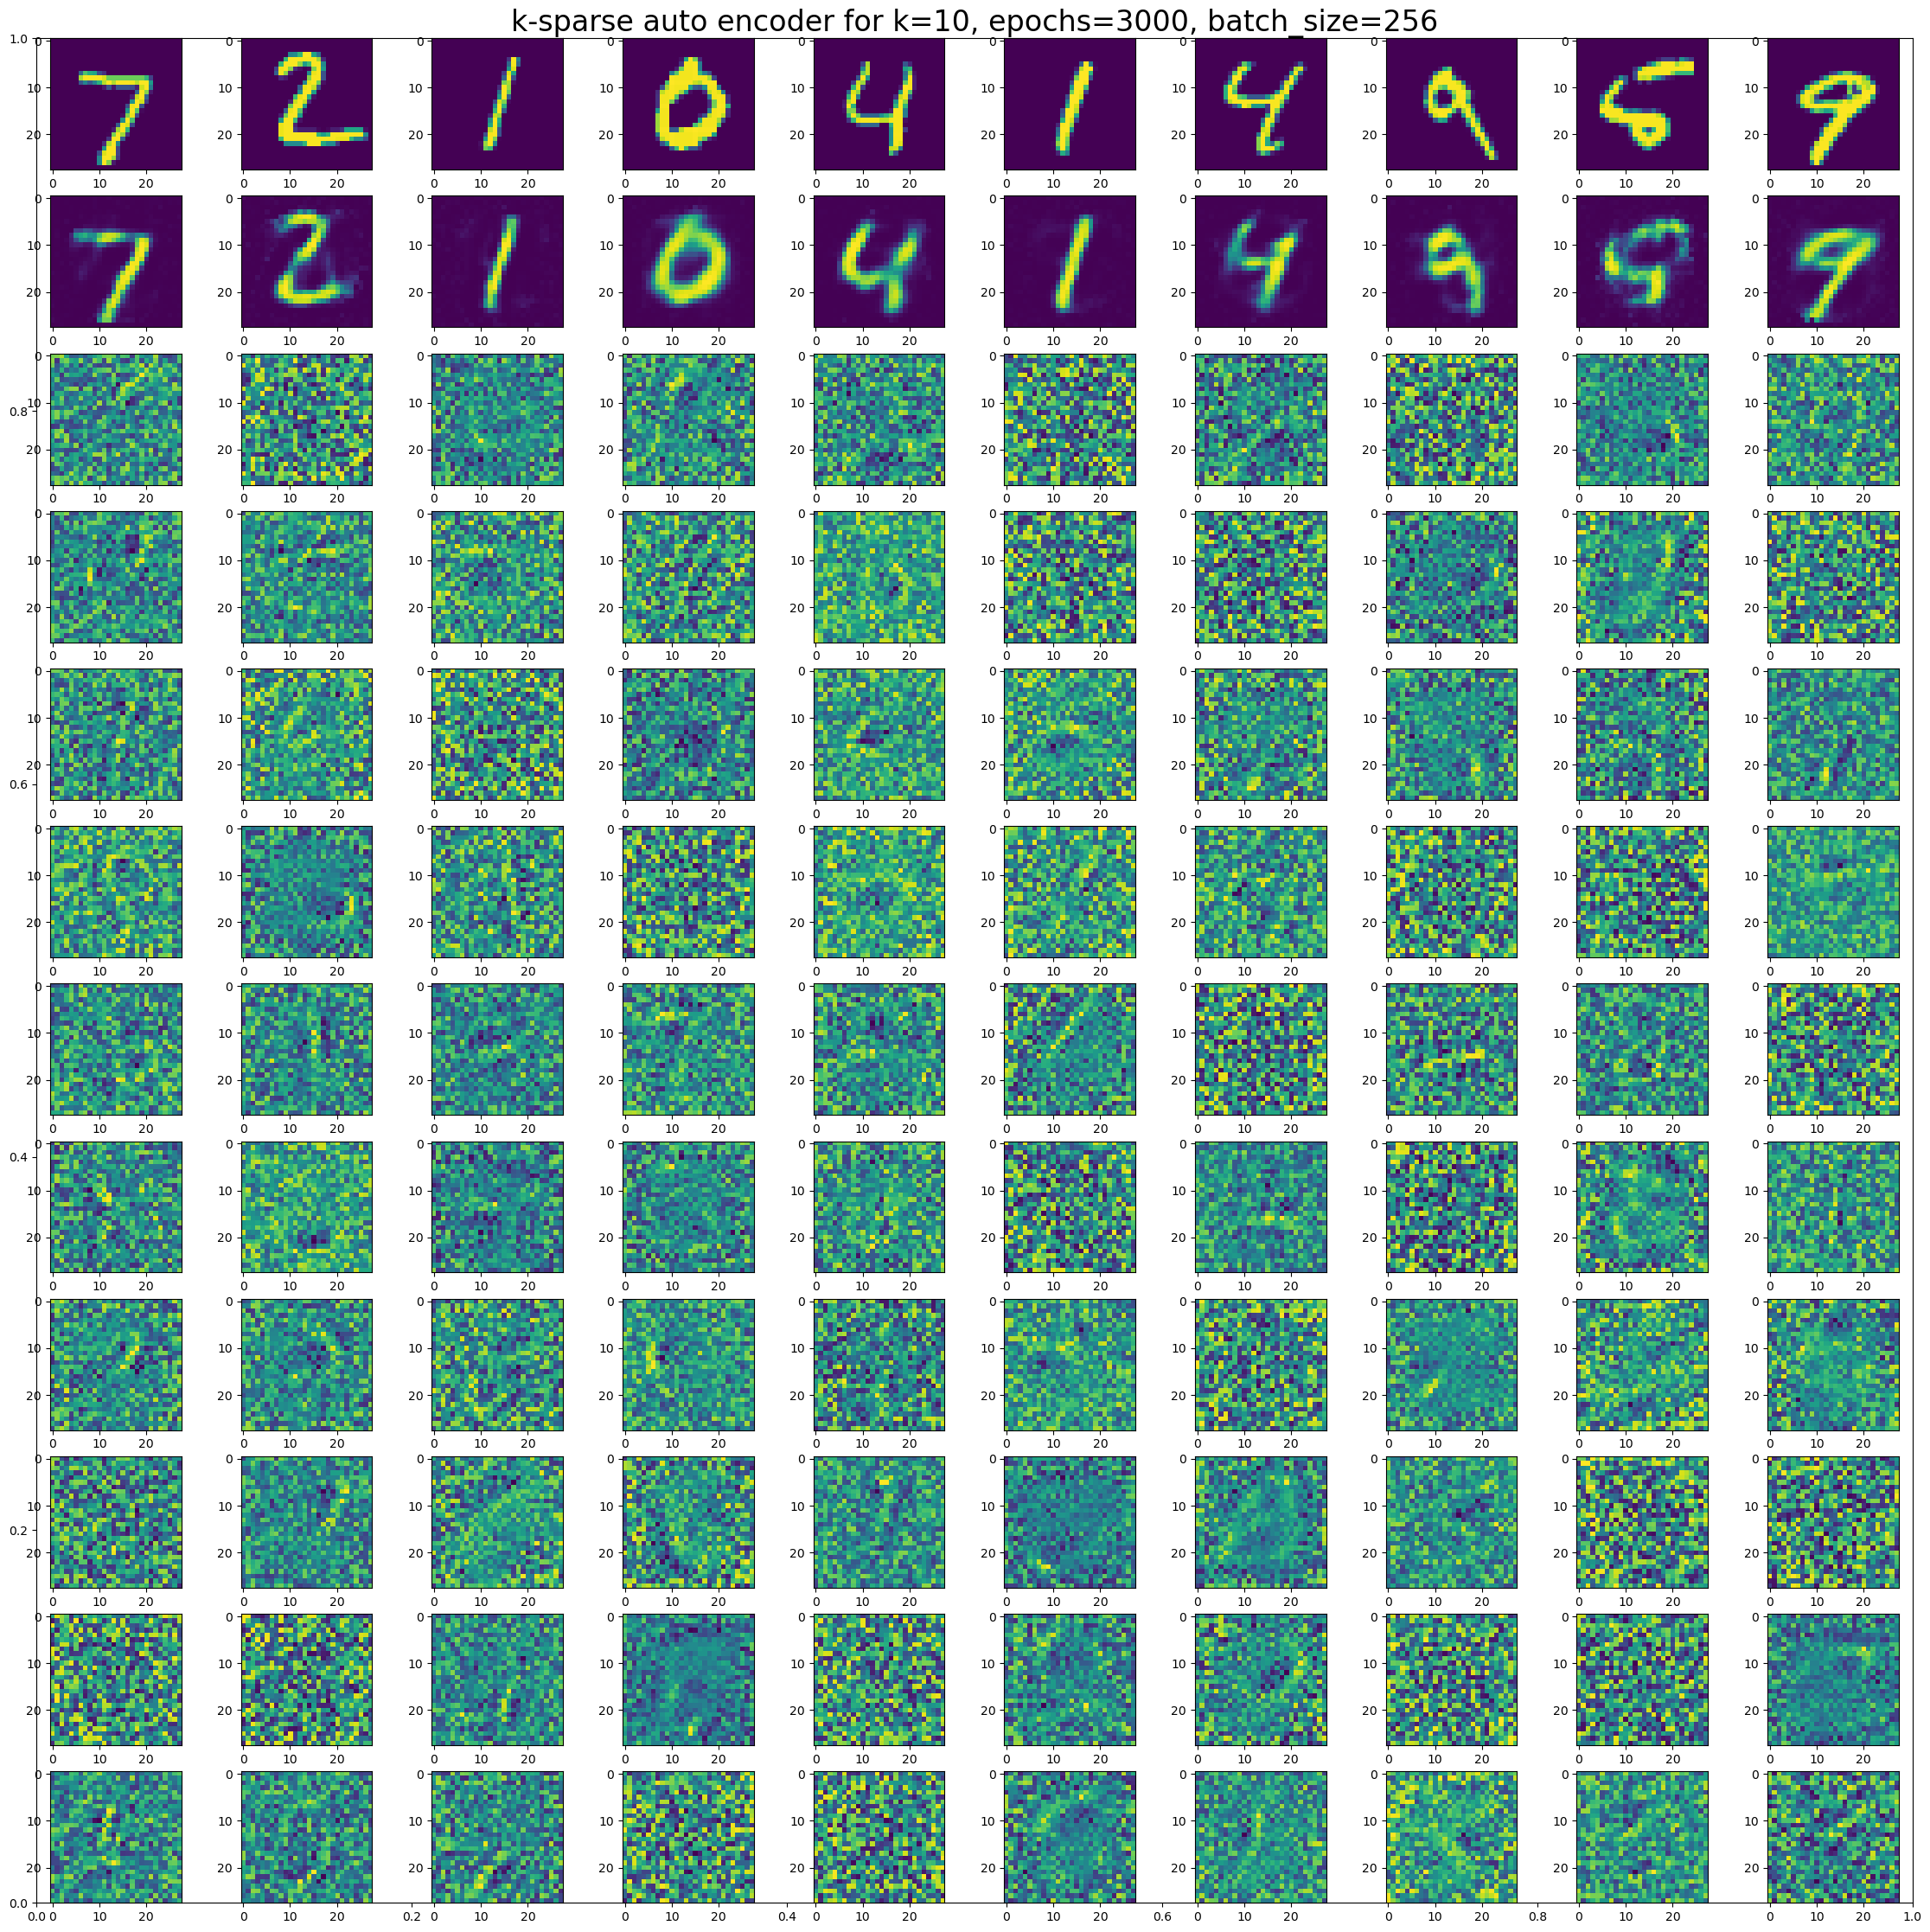

In [18]:
def auto_encoder():
    img_size = 28
    num_hidden = 100
    k = 10
    learning_rate = 0.01
    epochs = 3000
    batch_size = 256
    print_epochs = 1000
    num_test_examples = 10

    helper = mnist_helper()
    train_lbl, train_img, test_lbl, test_img = helper.get_data()

    x_data = train_img.reshape(-1, img_size * img_size) / np.float32(256)
    test_data = test_img.reshape(-1, img_size * img_size) / np.float32(256)

    layers = [
        # LinearLayer(name="input", n_in=x_data.shape[1], n_out=num_hidden, activation=sigmoid_function),
        SparseLayer(name="hidden 1", n_in=x_data.shape[1], n_out=num_hidden,
                    activation=sigmoid_function, num_k_sparse=k),
        LinearLayer(name="output", n_in=num_hidden, n_out=x_data.shape[1], activation=sigmoid_function)
    ]

    nn = FCNeuralNet(layers=layers, cost_func=subtract_err)
    nn.print_network()

    nn.train(x_data, x_data, learning_rate=learning_rate, epochs=epochs,
             batch_size=batch_size, print_epochs=print_epochs)

    # Encode and decode images from test set and visualize their reconstruction.
    n = num_test_examples

    test_samples = test_data[0:n]
    encode_samples = nn.layers[0].weights.T
    output_samples = nn.predict(test_samples)

    print("encode_samples", encode_samples.shape)
    print("Output shape", output_samples.shape)

    img_input = test_samples.reshape(-1, img_size, img_size)
    img_encode = encode_samples.reshape(-1, img_size, img_size)
    img_output = output_samples.reshape(-1, img_size, img_size)

    title = "k-sparse auto encoder for k={0}, epochs={1}, batch_size={2}".format(k, epochs, batch_size)
    all_images = np.concatenate((img_input, img_output, img_encode))

    add_plot_images(all_images, cols=10, img_size=img_size, title=title)

    plt.show()


def add_plot_images(images, cols=10, img_size=28, title=None):
    n_images = len(images)
    fig = plt.figure(figsize=(img_size, img_size))
    plt.title(title, fontsize=24)
    # plt.gray()
    rows = int(n_images / cols)
    for i in range(1, n_images + 1):
        img = images[i - 1]
        fig.add_subplot(rows, cols, i)
        plt.imshow(img)


def main():
    auto_encoder()
    


if __name__ == '__main__':
    main()


network:
layer - hidden 1: weights: (784, 100)
layer - output: weights: (100, 784)
training start
epochs: 1000, loss: 0.0639
epochs: 2000, loss: 0.0579
epochs: 3000, loss: 0.0552
training complete, elapsed time: 00:00:41
encode_samples (100, 784)
Output shape (10, 784)


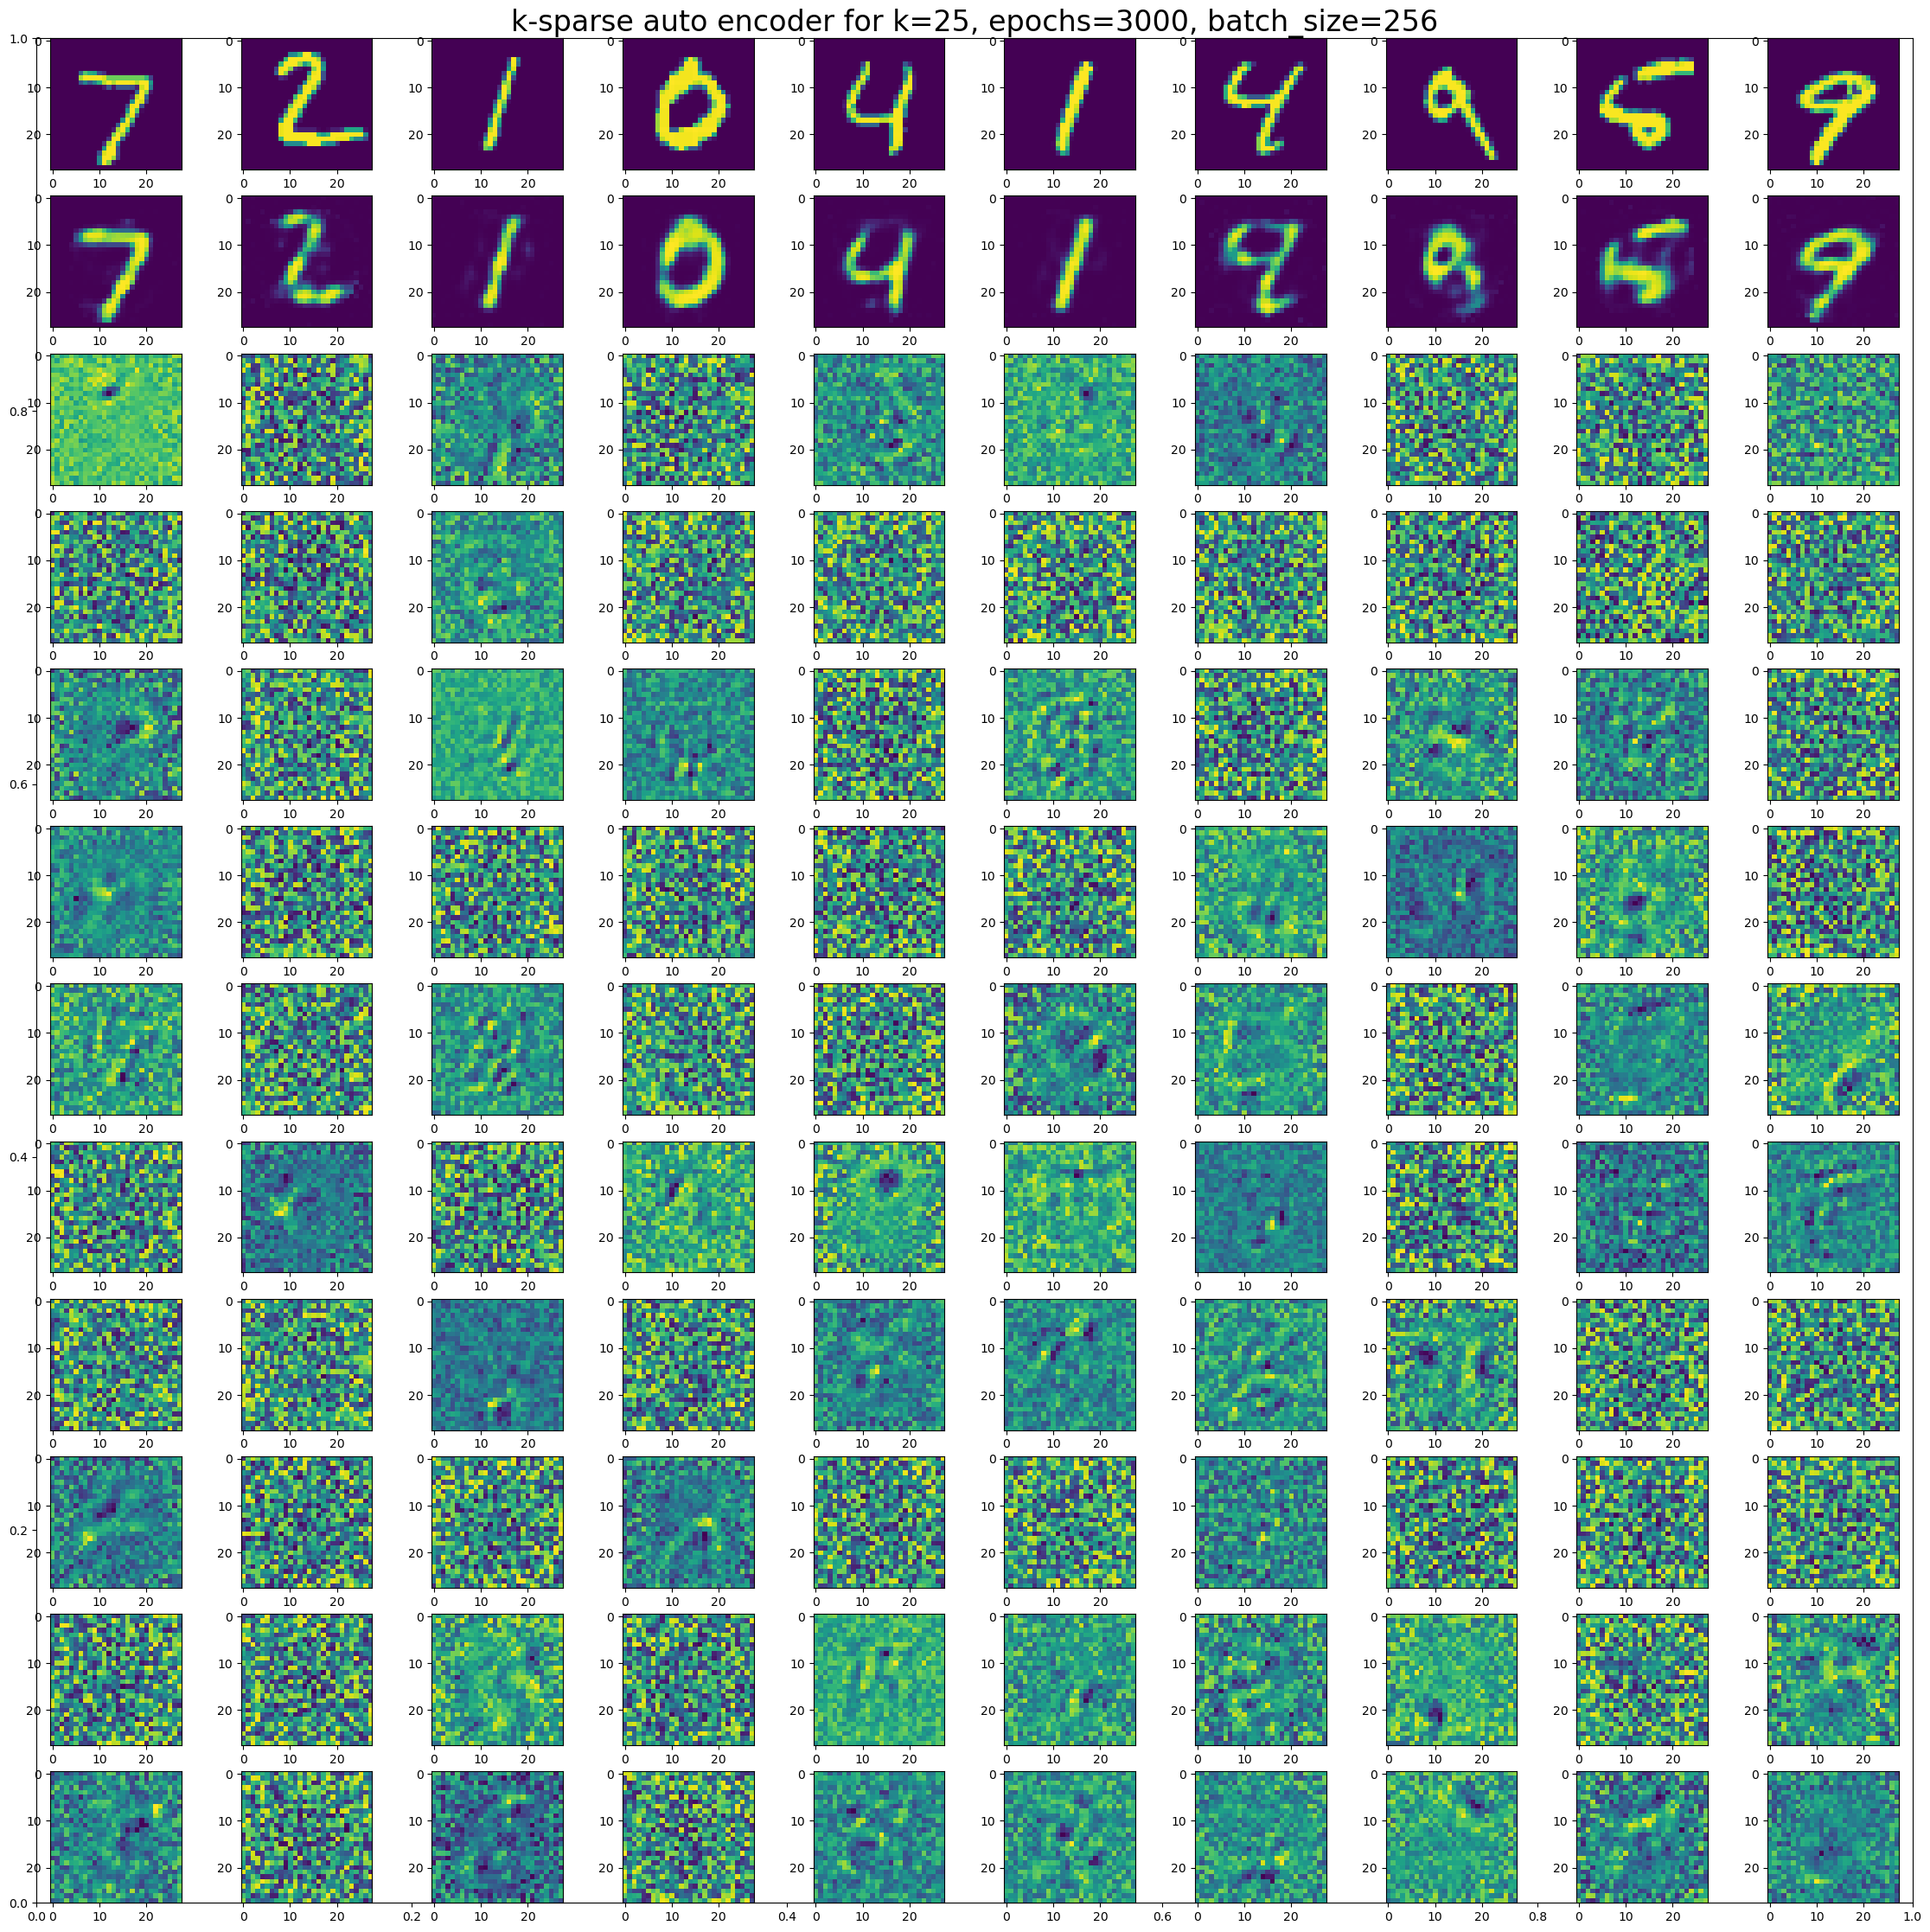

In [19]:
def auto_encoder():
    img_size = 28
    num_hidden = 100
    k = 25
    learning_rate = 0.01
    epochs = 3000
    batch_size = 256
    print_epochs = 1000
    num_test_examples = 10

    helper = mnist_helper()
    train_lbl, train_img, test_lbl, test_img = helper.get_data()

    x_data = train_img.reshape(-1, img_size * img_size) / np.float32(256)
    test_data = test_img.reshape(-1, img_size * img_size) / np.float32(256)

    layers = [
        # LinearLayer(name="input", n_in=x_data.shape[1], n_out=num_hidden, activation=sigmoid_function),
        SparseLayer(name="hidden 1", n_in=x_data.shape[1], n_out=num_hidden,
                    activation=sigmoid_function, num_k_sparse=k),
        LinearLayer(name="output", n_in=num_hidden, n_out=x_data.shape[1], activation=sigmoid_function)
    ]

    nn = FCNeuralNet(layers=layers, cost_func=subtract_err)
    nn.print_network()

    nn.train(x_data, x_data, learning_rate=learning_rate, epochs=epochs,
             batch_size=batch_size, print_epochs=print_epochs)

    # Encode and decode images from test set and visualize their reconstruction.
    n = num_test_examples

    test_samples = test_data[0:n]
    encode_samples = nn.layers[0].weights.T
    output_samples = nn.predict(test_samples)

    print("encode_samples", encode_samples.shape)
    print("Output shape", output_samples.shape)

    img_input = test_samples.reshape(-1, img_size, img_size)
    img_encode = encode_samples.reshape(-1, img_size, img_size)
    img_output = output_samples.reshape(-1, img_size, img_size)

    title = "k-sparse auto encoder for k={0}, epochs={1}, batch_size={2}".format(k, epochs, batch_size)
    all_images = np.concatenate((img_input, img_output, img_encode))

    add_plot_images(all_images, cols=10, img_size=img_size, title=title)

    plt.show()


def add_plot_images(images, cols=10, img_size=28, title=None):
    n_images = len(images)
    fig = plt.figure(figsize=(img_size, img_size))
    plt.title(title, fontsize=24)
    # plt.gray()
    rows = int(n_images / cols)
    for i in range(1, n_images + 1):
        img = images[i - 1]
        fig.add_subplot(rows, cols, i)
        plt.imshow(img)


def main():
    auto_encoder()
   

if __name__ == '__main__':
    main()


network:
layer - hidden 1: weights: (784, 100)
layer - output: weights: (100, 784)
training start
epochs: 1000, loss: 0.0978
epochs: 2000, loss: 0.0770
epochs: 3000, loss: 0.0744
training complete, elapsed time: 00:00:06
encode_samples (100, 784)
Output shape (10, 784)


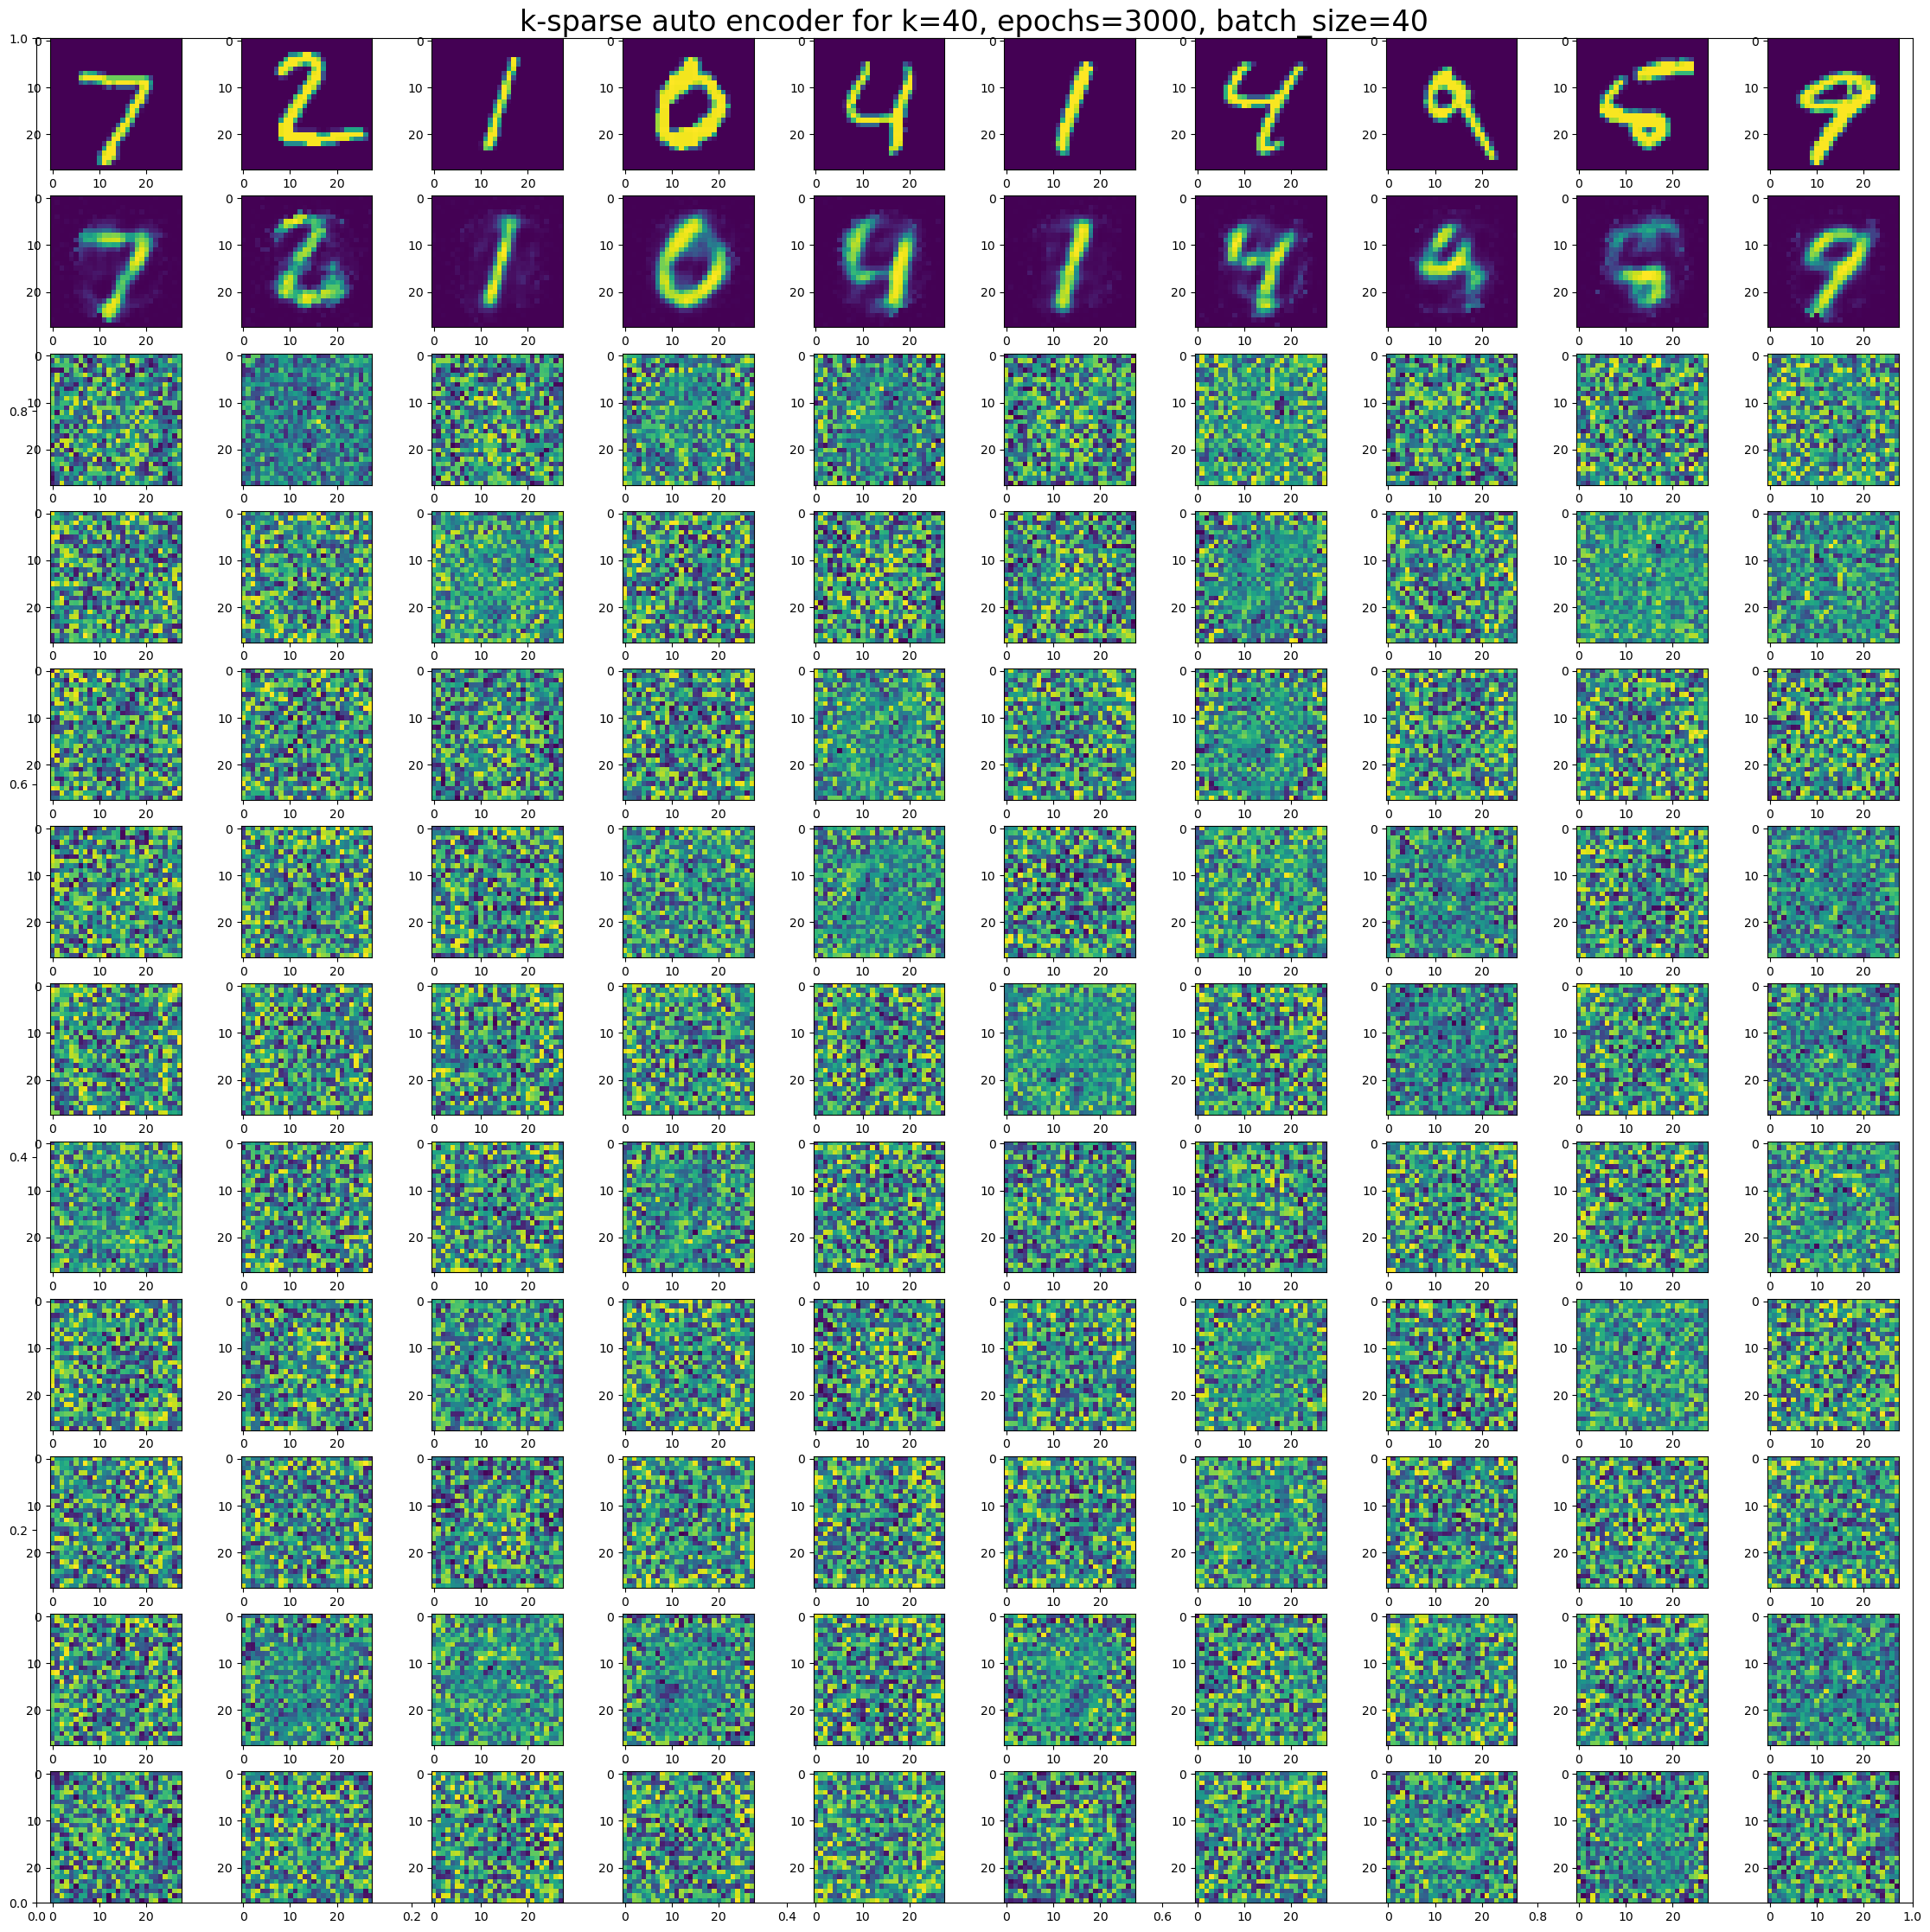

In [20]:
def auto_encoder():
    img_size = 28
    num_hidden = 100
    k = 40
    learning_rate = 0.01
    epochs = 3000
    batch_size = 40
    print_epochs = 1000
    num_test_examples = 10

    helper = mnist_helper()
    train_lbl, train_img, test_lbl, test_img = helper.get_data()

    x_data = train_img.reshape(-1, img_size * img_size) / np.float32(256)
    test_data = test_img.reshape(-1, img_size * img_size) / np.float32(256)

    layers = [
        # LinearLayer(name="input", n_in=x_data.shape[1], n_out=num_hidden, activation=sigmoid_function),
        SparseLayer(name="hidden 1", n_in=x_data.shape[1], n_out=num_hidden,
                    activation=sigmoid_function, num_k_sparse=k),
        LinearLayer(name="output", n_in=num_hidden, n_out=x_data.shape[1], activation=sigmoid_function)
    ]

    nn = FCNeuralNet(layers=layers, cost_func=subtract_err)
    nn.print_network()

    nn.train(x_data, x_data, learning_rate=learning_rate, epochs=epochs,
             batch_size=batch_size, print_epochs=print_epochs)

    # Encode and decode images from test set and visualize their reconstruction.
    n = num_test_examples

    test_samples = test_data[0:n]
    encode_samples = nn.layers[0].weights.T
    output_samples = nn.predict(test_samples)

    print("encode_samples", encode_samples.shape)
    print("Output shape", output_samples.shape)

    img_input = test_samples.reshape(-1, img_size, img_size)
    img_encode = encode_samples.reshape(-1, img_size, img_size)
    img_output = output_samples.reshape(-1, img_size, img_size)

    title = "k-sparse auto encoder for k={0}, epochs={1}, batch_size={2}".format(k, epochs, batch_size)
    all_images = np.concatenate((img_input, img_output, img_encode))

    add_plot_images(all_images, cols=10, img_size=img_size, title=title)

    plt.show()


def add_plot_images(images, cols=10, img_size=28, title=None):
    n_images = len(images)
    fig = plt.figure(figsize=(img_size, img_size))
    plt.title(title, fontsize=24)
    # plt.gray()
    rows = int(n_images / cols)
    for i in range(1, n_images + 1):
        img = images[i - 1]
        fig.add_subplot(rows, cols, i)
        plt.imshow(img)


def main():
    auto_encoder()
   

if __name__ == '__main__':
    main()


network:
layer - hidden 1: weights: (784, 100)
layer - output: weights: (100, 784)
training start
epochs: 1000, loss: 0.0589
epochs: 2000, loss: 0.0527
epochs: 3000, loss: 0.0466
training complete, elapsed time: 00:00:41
encode_samples (100, 784)
Output shape (10, 784)


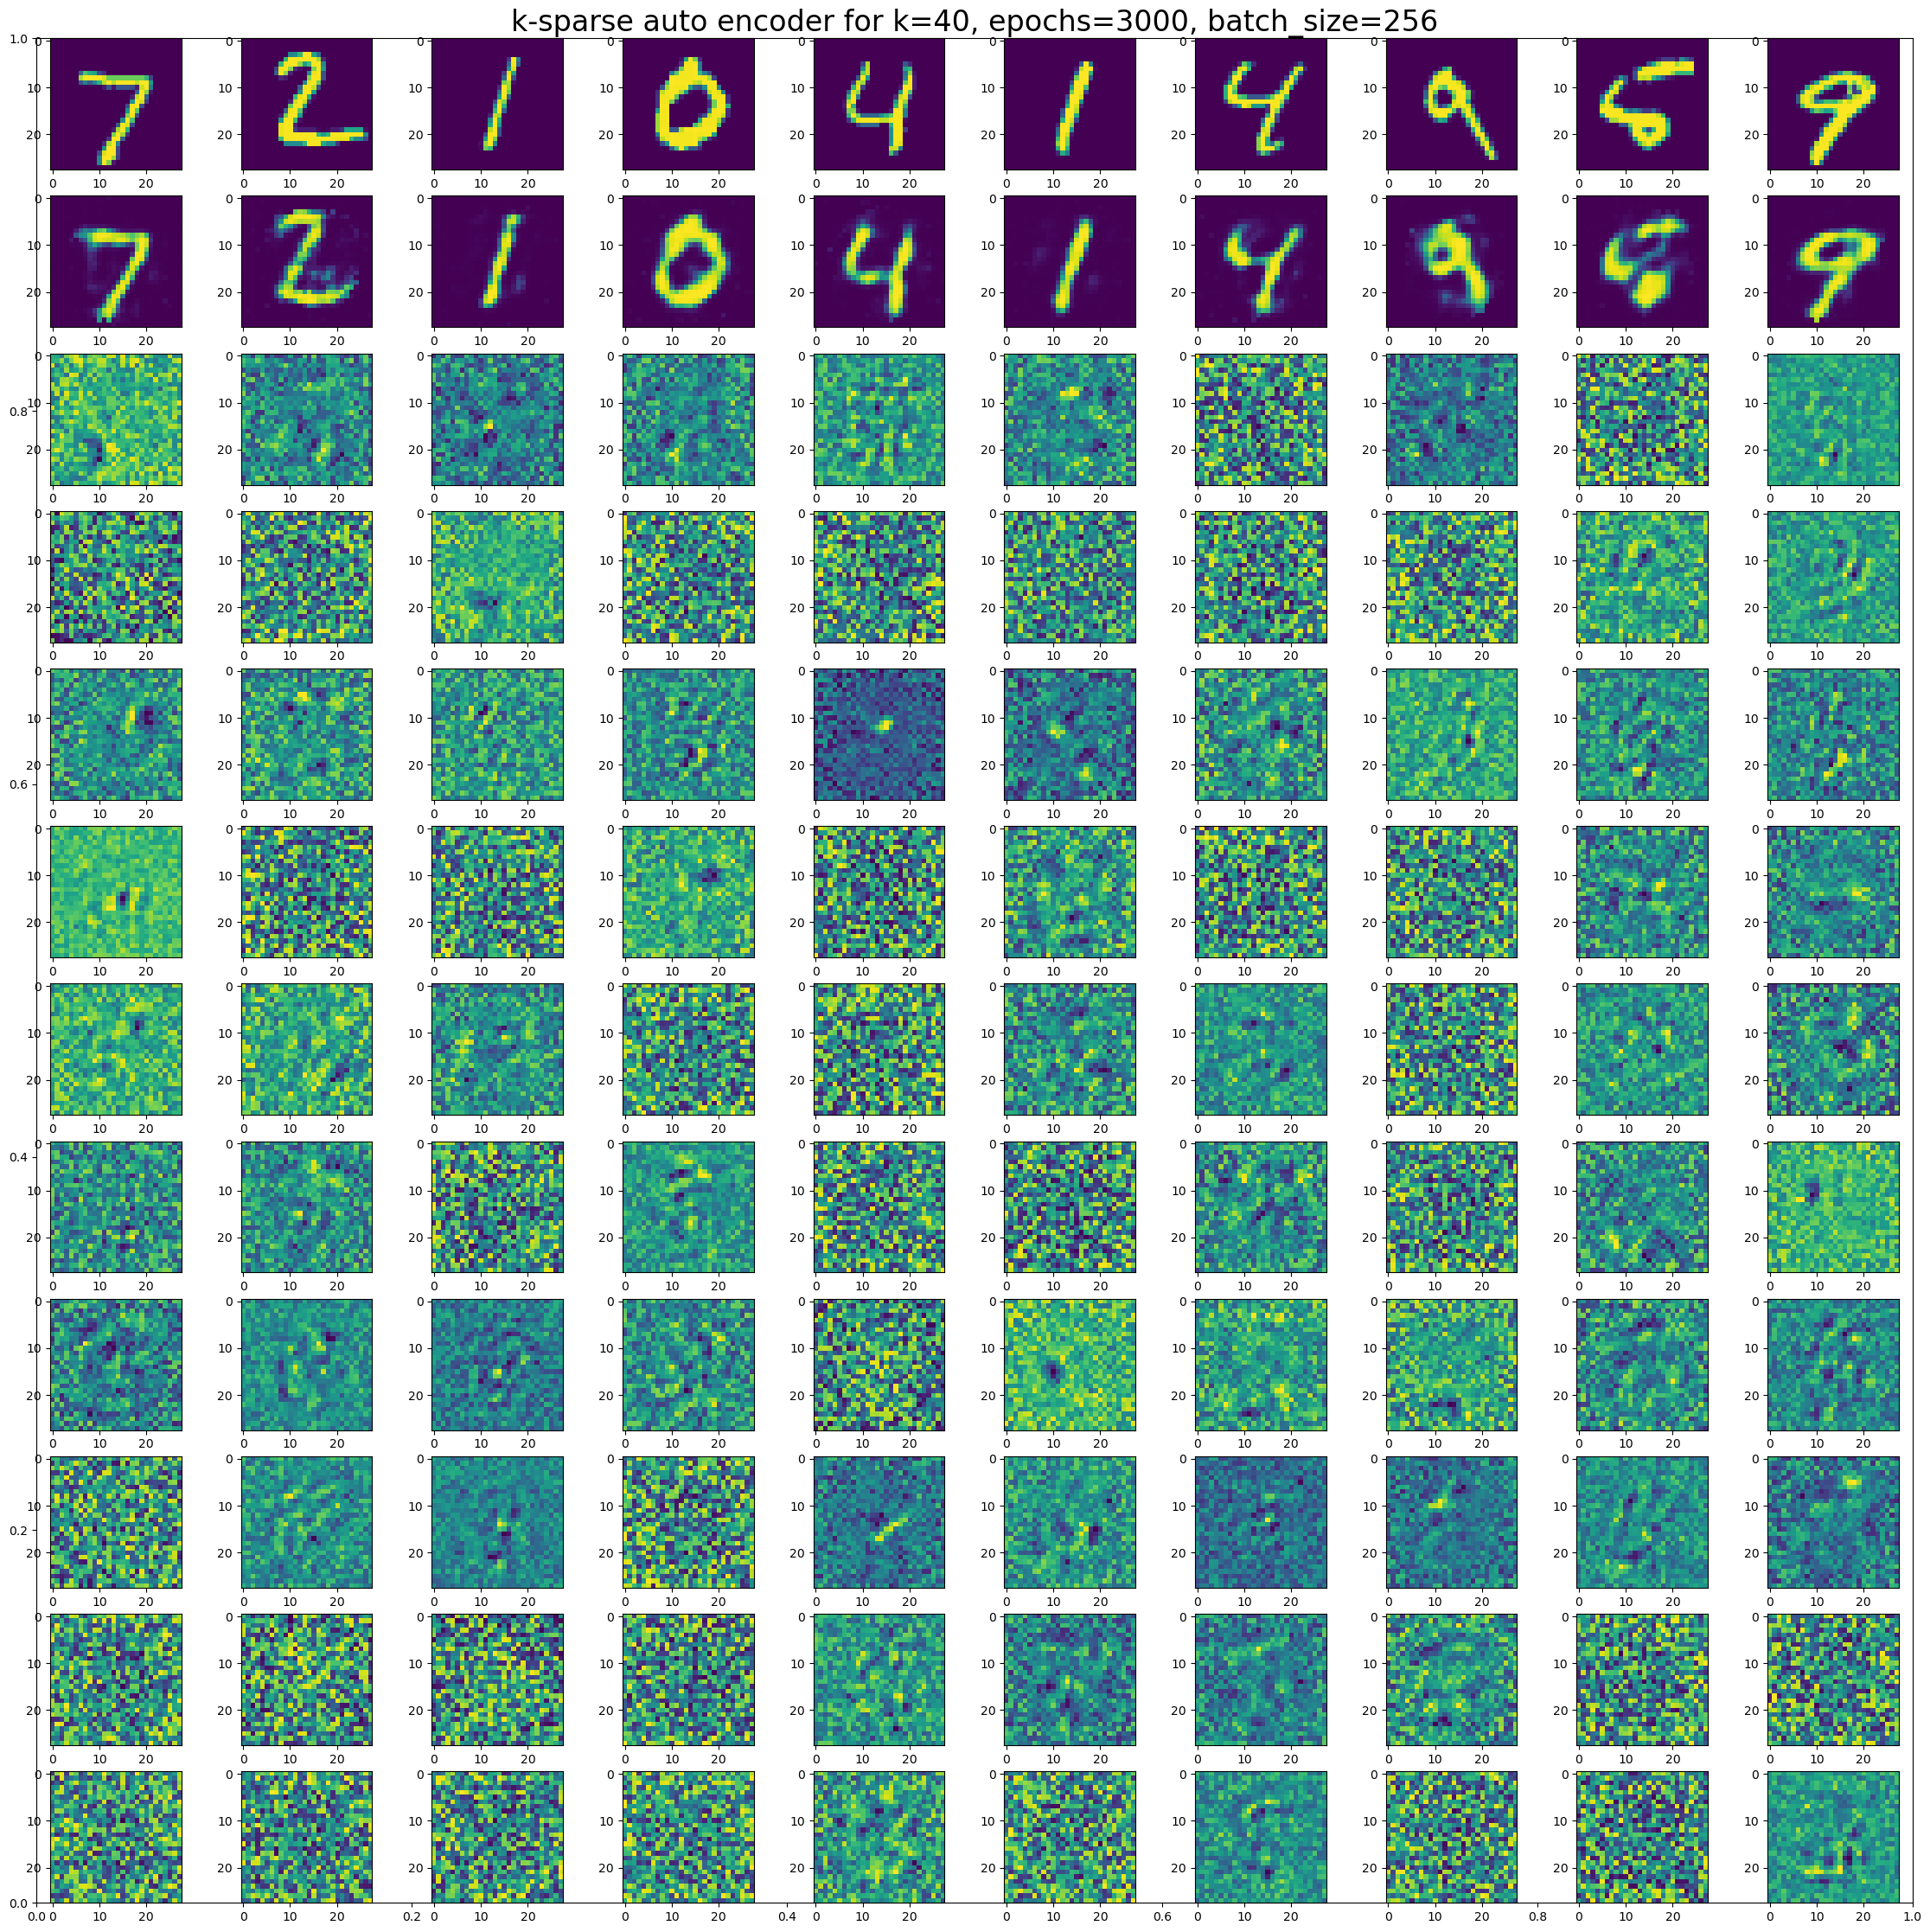

In [21]:
def auto_encoder():
    img_size = 28
    num_hidden = 100
    k = 40
    learning_rate = 0.01
    epochs = 3000
    batch_size = 256
    print_epochs = 1000
    num_test_examples = 10

    helper = mnist_helper()
    train_lbl, train_img, test_lbl, test_img = helper.get_data()

    x_data = train_img.reshape(-1, img_size * img_size) / np.float32(256)
    test_data = test_img.reshape(-1, img_size * img_size) / np.float32(256)

    layers = [
        # LinearLayer(name="input", n_in=x_data.shape[1], n_out=num_hidden, activation=sigmoid_function),
        SparseLayer(name="hidden 1", n_in=x_data.shape[1], n_out=num_hidden,
                    activation=sigmoid_function, num_k_sparse=k),
        LinearLayer(name="output", n_in=num_hidden, n_out=x_data.shape[1], activation=sigmoid_function)
    ]

    nn = FCNeuralNet(layers=layers, cost_func=subtract_err)
    nn.print_network()

    nn.train(x_data, x_data, learning_rate=learning_rate, epochs=epochs,
             batch_size=batch_size, print_epochs=print_epochs)

    # Encode and decode images from test set and visualize their reconstruction.
    n = num_test_examples

    test_samples = test_data[0:n]
    encode_samples = nn.layers[0].weights.T
    output_samples = nn.predict(test_samples)

    print("encode_samples", encode_samples.shape)
    print("Output shape", output_samples.shape)

    img_input = test_samples.reshape(-1, img_size, img_size)
    img_encode = encode_samples.reshape(-1, img_size, img_size)
    img_output = output_samples.reshape(-1, img_size, img_size)

    title = "k-sparse auto encoder for k={0}, epochs={1}, batch_size={2}".format(k, epochs, batch_size)
    all_images = np.concatenate((img_input, img_output, img_encode))

    add_plot_images(all_images, cols=10, img_size=img_size, title=title)

    plt.show()


def add_plot_images(images, cols=10, img_size=28, title=None):
    n_images = len(images)
    fig = plt.figure(figsize=(img_size, img_size))
    plt.title(title, fontsize=24)
    # plt.gray()
    rows = int(n_images / cols)
    for i in range(1, n_images + 1):
        img = images[i - 1]
        fig.add_subplot(rows, cols, i)
        plt.imshow(img)


def main():
    auto_encoder()
    

if __name__ == '__main__':
    main()


network:
layer - hidden 1: weights: (784, 100)
layer - output: weights: (100, 784)
training start
epochs: 1000, loss: 0.0542
epochs: 2000, loss: 0.0440
epochs: 3000, loss: 0.0416
training complete, elapsed time: 00:00:41
encode_samples (100, 784)
Output shape (10, 784)


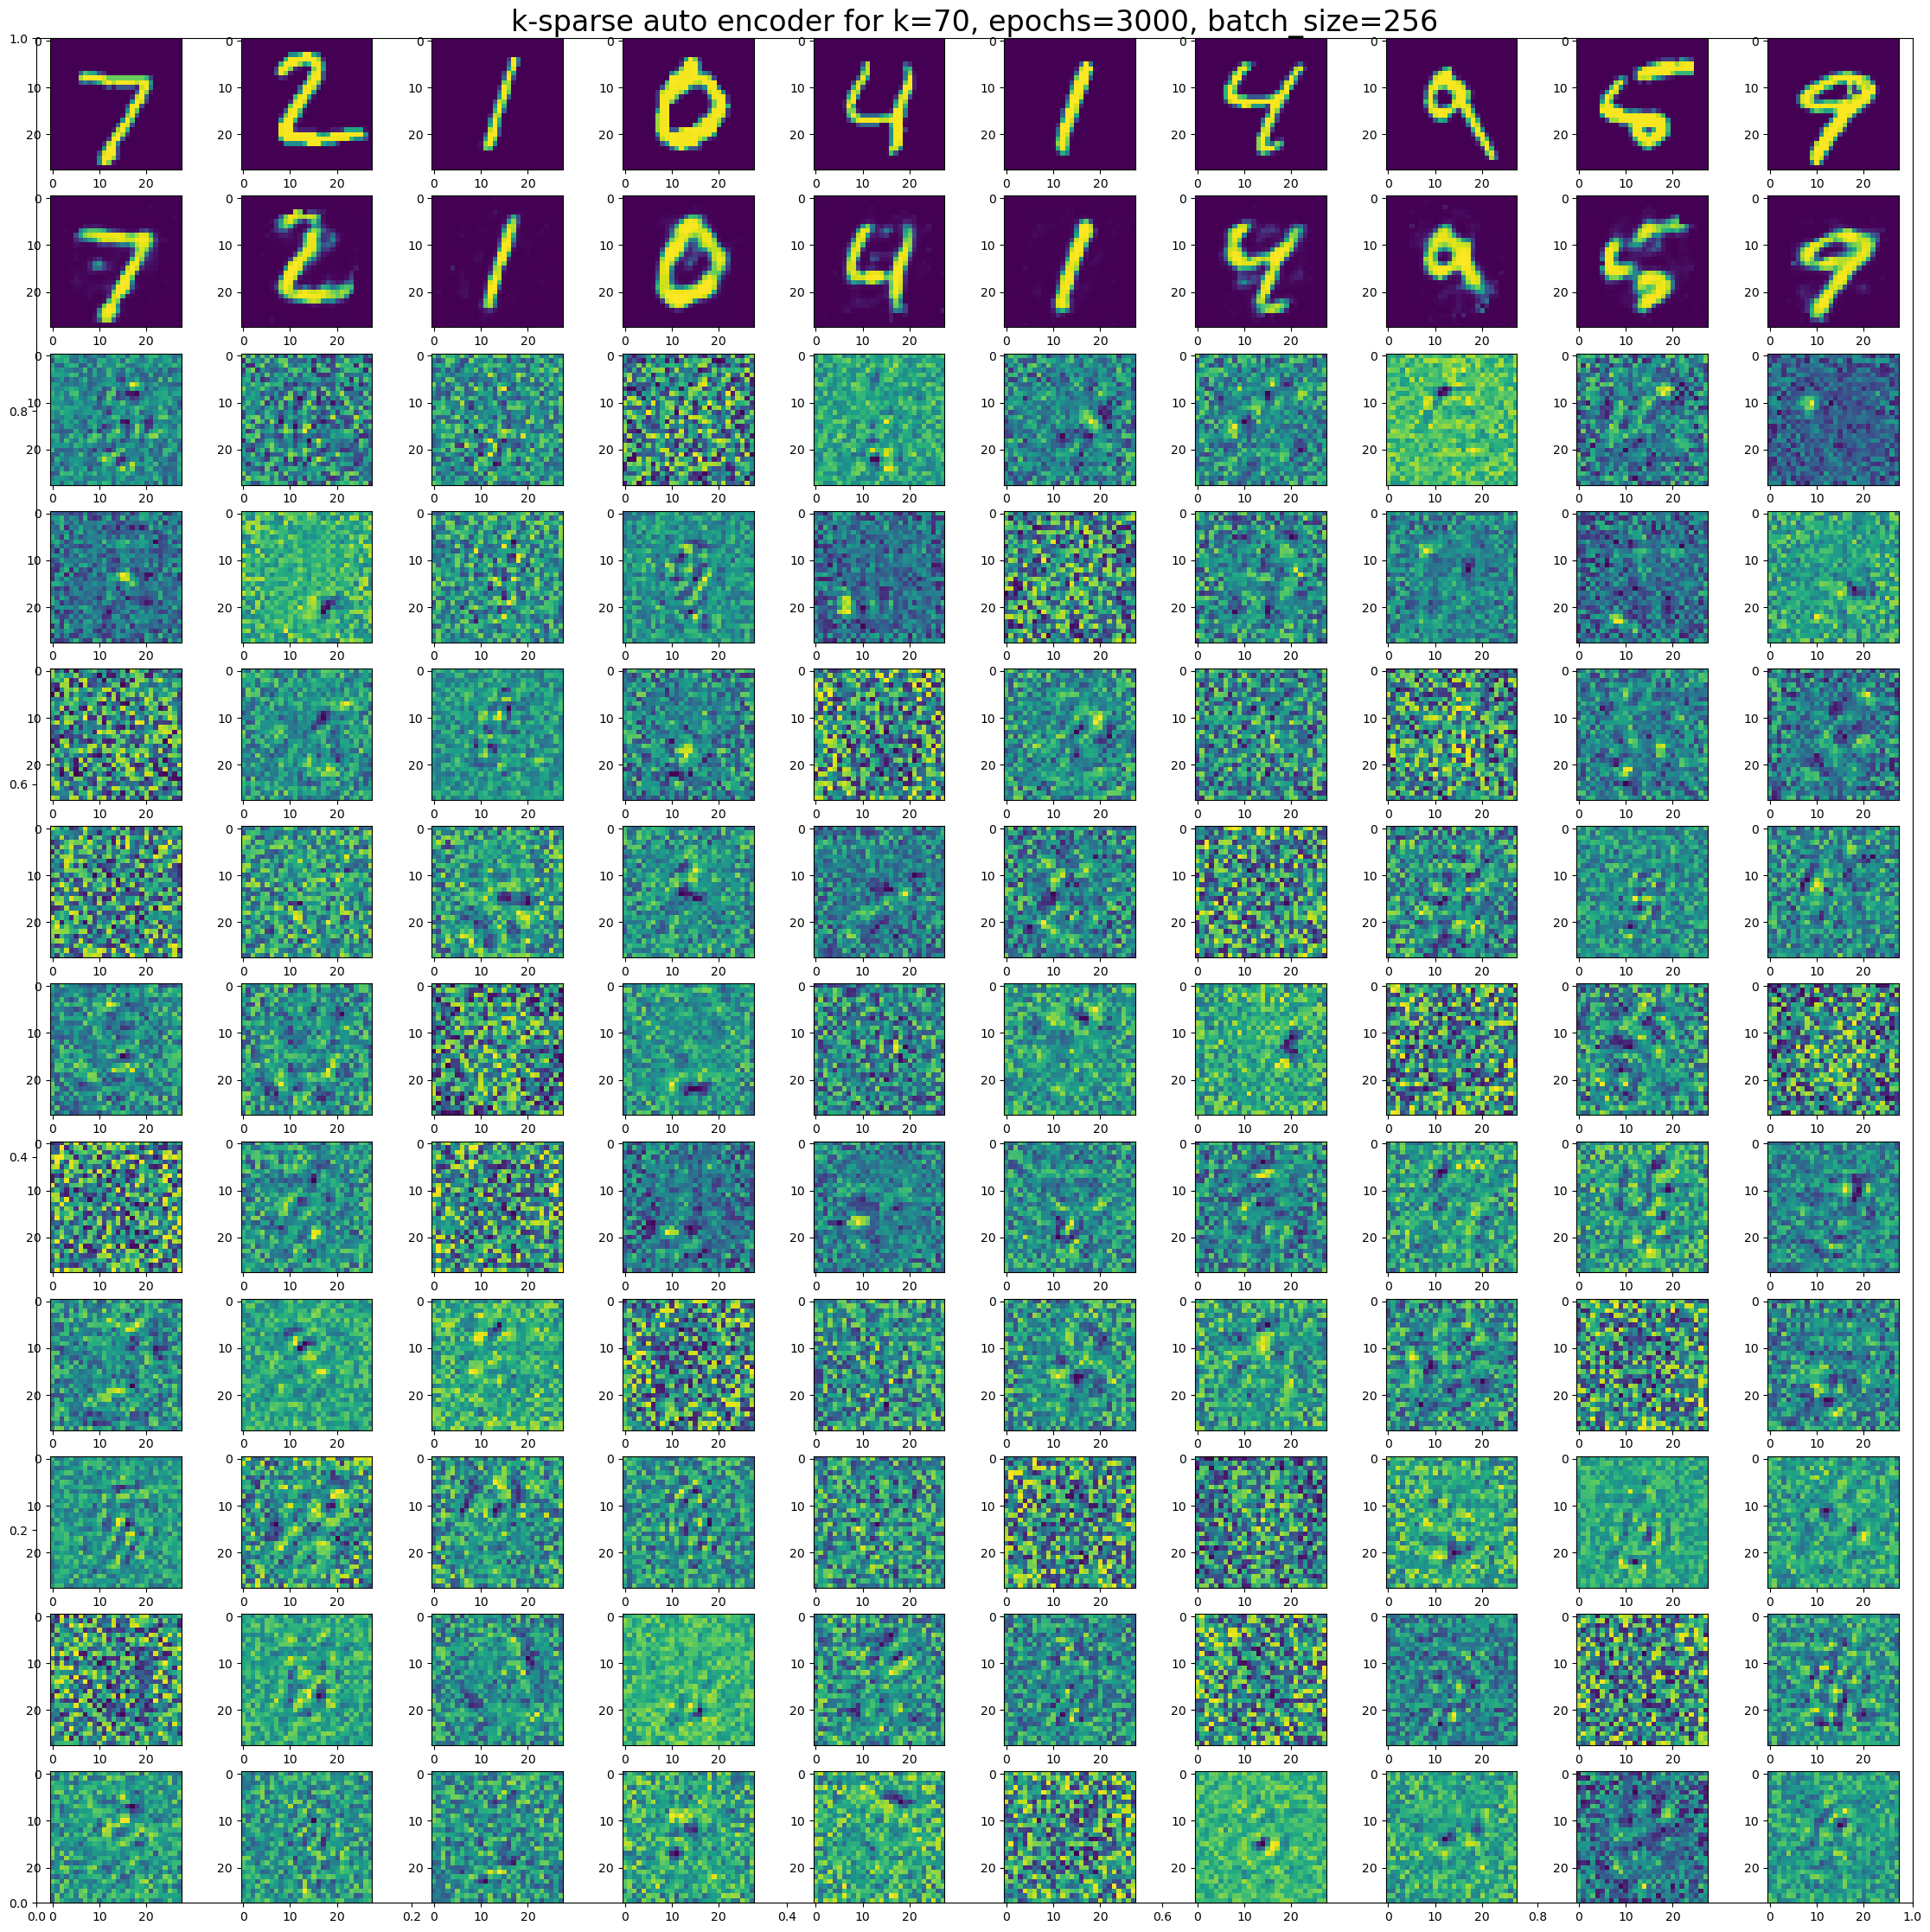

In [22]:
def auto_encoder():
    img_size = 28
    num_hidden = 100
    k = 70
    learning_rate = 0.01
    epochs = 3000
    batch_size = 256
    print_epochs = 1000
    num_test_examples = 10

    helper = mnist_helper()
    train_lbl, train_img, test_lbl, test_img = helper.get_data()

    x_data = train_img.reshape(-1, img_size * img_size) / np.float32(256)
    test_data = test_img.reshape(-1, img_size * img_size) / np.float32(256)

    layers = [        
        SparseLayer(name="hidden 1", n_in=x_data.shape[1], n_out=num_hidden,
                    activation=sigmoid_function, num_k_sparse=k),
        LinearLayer(name="output", n_in=num_hidden, n_out=x_data.shape[1], activation=sigmoid_function)
    ]

    nn = FCNeuralNet(layers=layers, cost_func=subtract_err)
    nn.print_network()

    nn.train(x_data, x_data, learning_rate=learning_rate, epochs=epochs,
             batch_size=batch_size, print_epochs=print_epochs)

    # Encode and decode images from test set and visualize their reconstruction.
    n = num_test_examples

    test_samples = test_data[0:n]
    encode_samples = nn.layers[0].weights.T
    output_samples = nn.predict(test_samples)

    print("encode_samples", encode_samples.shape)
    print("Output shape", output_samples.shape)

    img_input = test_samples.reshape(-1, img_size, img_size)
    img_encode = encode_samples.reshape(-1, img_size, img_size)
    img_output = output_samples.reshape(-1, img_size, img_size)

    title = "k-sparse auto encoder for k={0}, epochs={1}, batch_size={2}".format(k, epochs, batch_size)
    all_images = np.concatenate((img_input, img_output, img_encode))

    add_plot_images(all_images, cols=10, img_size=img_size, title=title)

    plt.show()


def add_plot_images(images, cols=10, img_size=28, title=None):
    n_images = len(images)
    fig = plt.figure(figsize=(img_size, img_size))
    plt.title(title, fontsize=24)
    # plt.gray()
    rows = int(n_images / cols)
    for i in range(1, n_images + 1):
        img = images[i - 1]
        fig.add_subplot(rows, cols, i)
        plt.imshow(img)


def main():
    auto_encoder()
    
if __name__ == '__main__':
    main()


network:
layer - hidden 1: weights: (784, 100)
layer - output: weights: (100, 784)
training start
epochs: 1000, loss: 0.0502
epochs: 2000, loss: 0.0458
epochs: 3000, loss: 0.0409
training complete, elapsed time: 00:00:35
encode_samples (100, 784)
Output shape (10, 784)


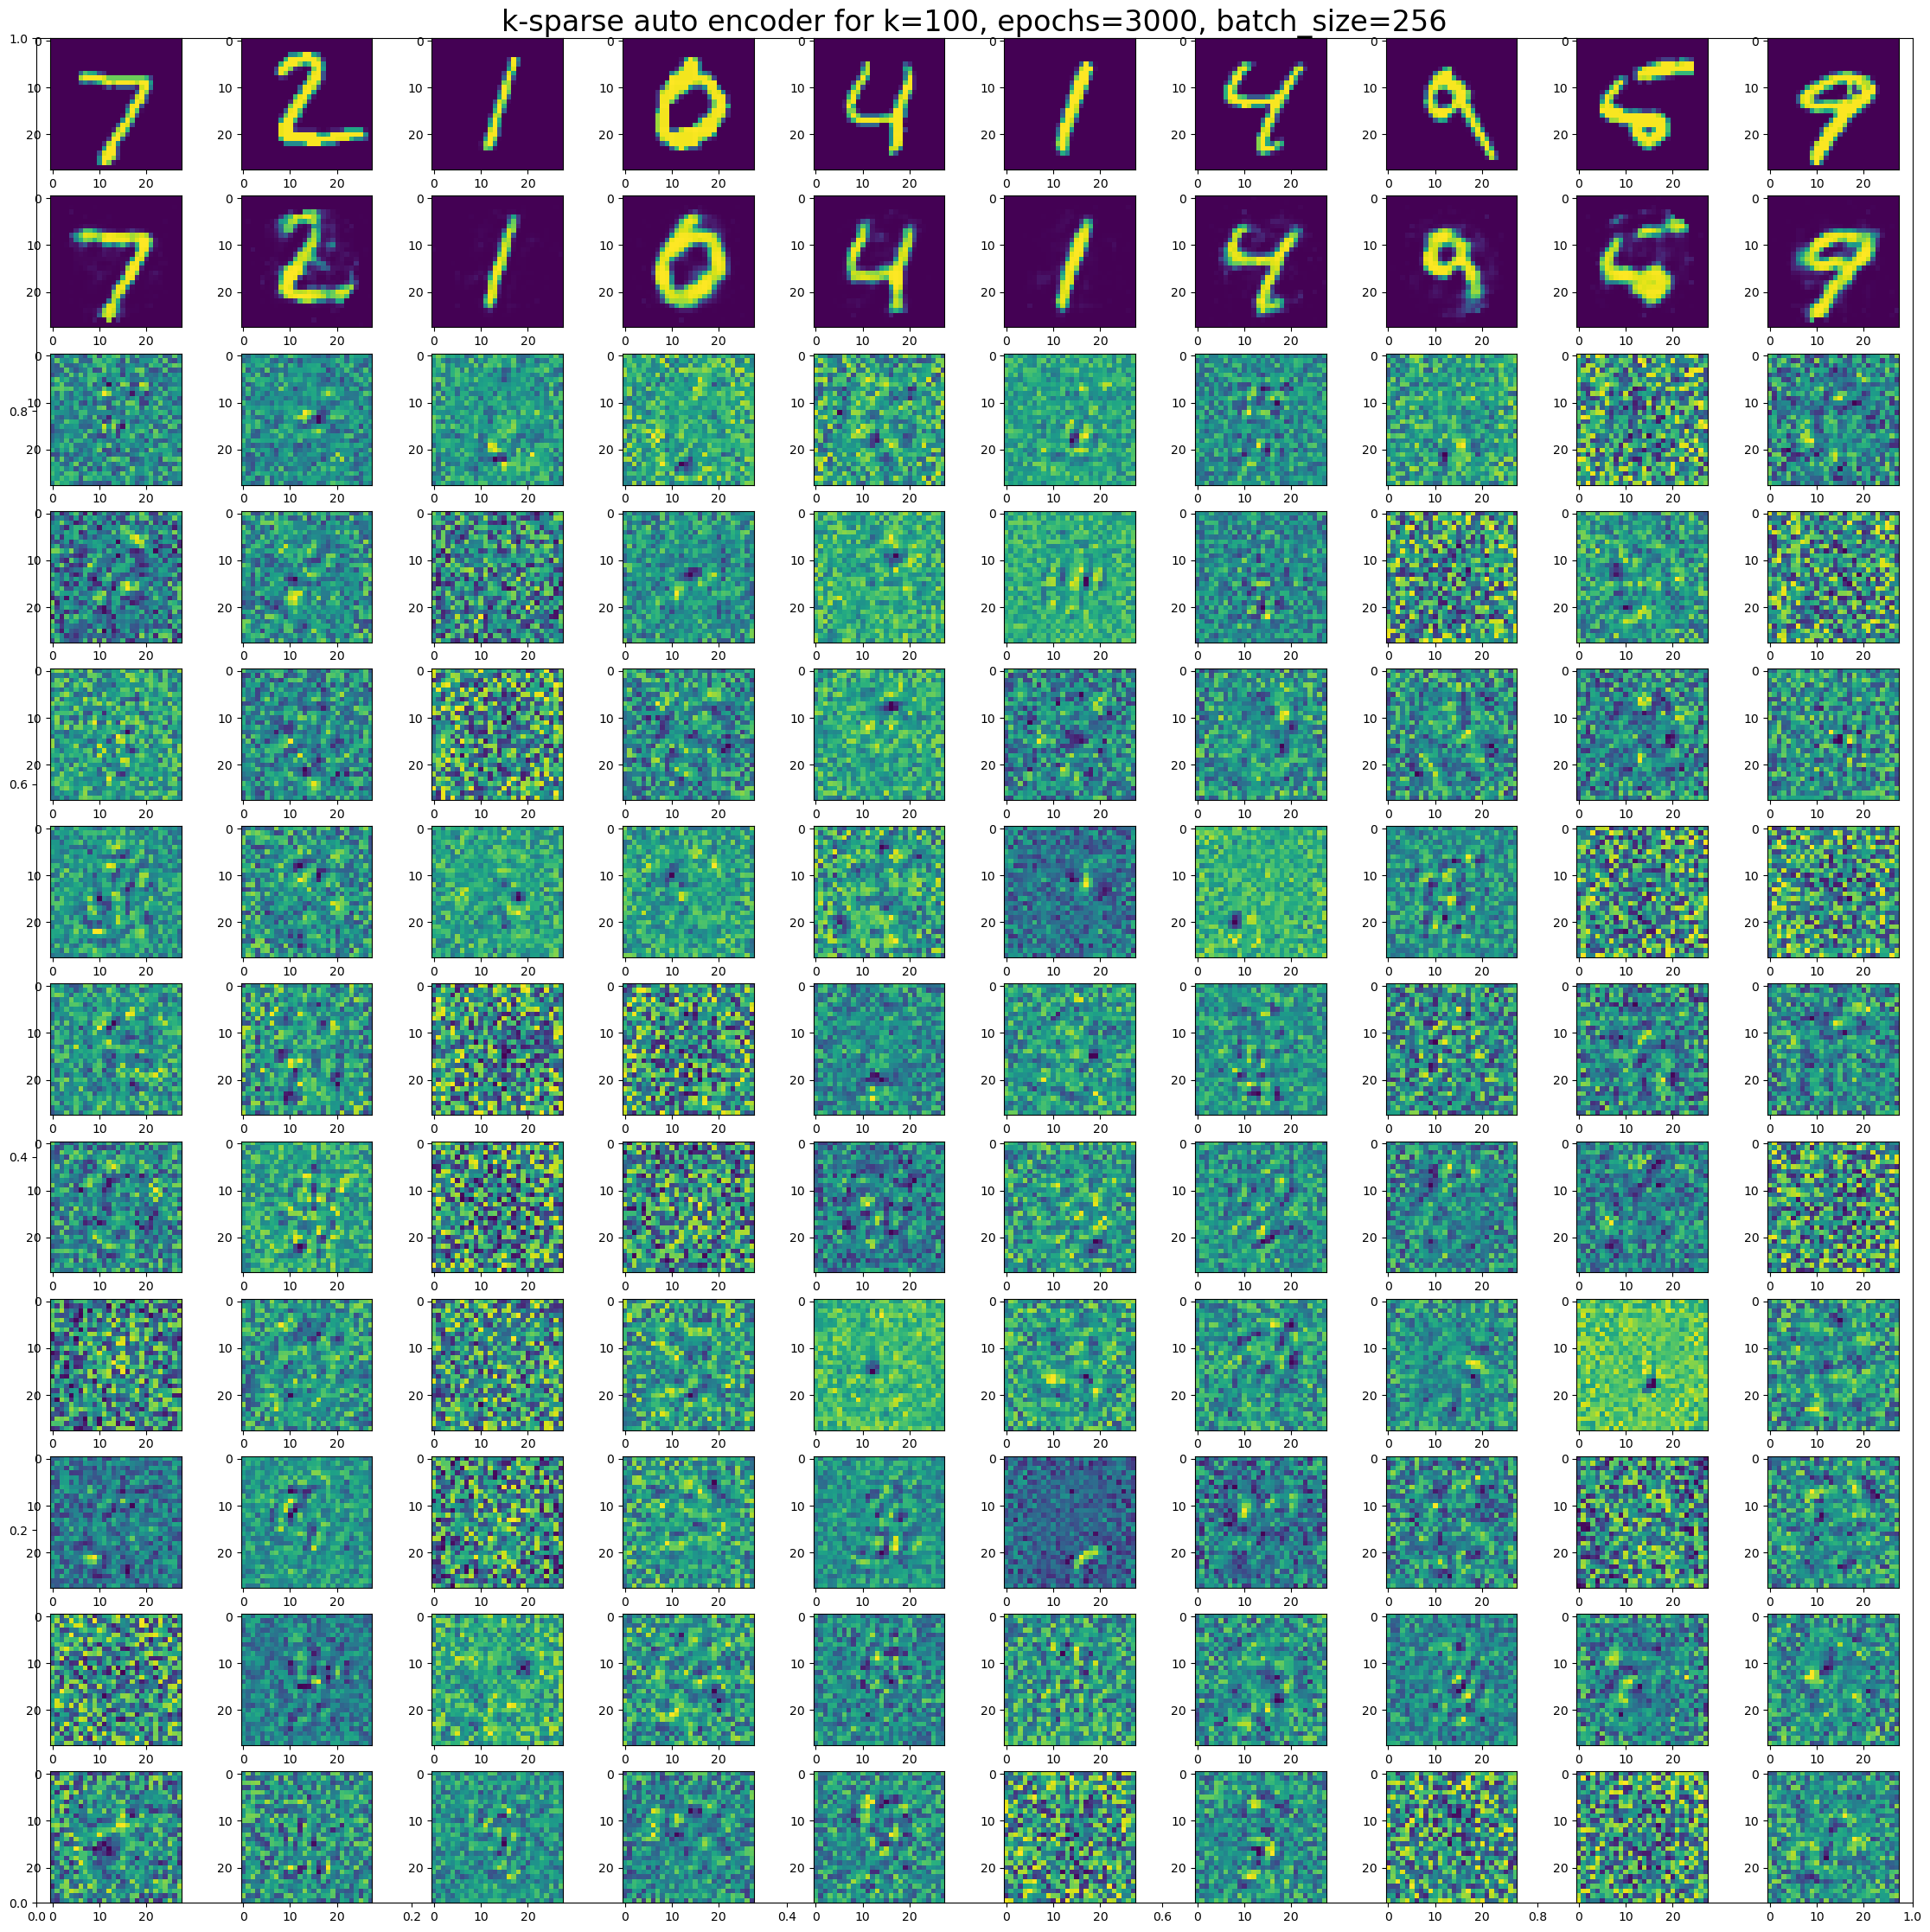

In [23]:
def auto_encoder():
    img_size = 28
    num_hidden = 100
    k = 100
    learning_rate = 0.01
    epochs = 3000
    batch_size = 256
    print_epochs = 1000
    num_test_examples = 10

    helper = mnist_helper()
    train_lbl, train_img, test_lbl, test_img = helper.get_data()

    x_data = train_img.reshape(-1, img_size * img_size) / np.float32(256)
    test_data = test_img.reshape(-1, img_size * img_size) / np.float32(256)

    layers = [        
        SparseLayer(name="hidden 1", n_in=x_data.shape[1], n_out=num_hidden,
                    activation=sigmoid_function, num_k_sparse=k),
        LinearLayer(name="output", n_in=num_hidden, n_out=x_data.shape[1], activation=sigmoid_function)
    ]

    nn = FCNeuralNet(layers=layers, cost_func=subtract_err)
    nn.print_network()

    nn.train(x_data, x_data, learning_rate=learning_rate, epochs=epochs,
             batch_size=batch_size, print_epochs=print_epochs)

    # Encode and decode images from test set and visualize their reconstruction.
    n = num_test_examples

    test_samples = test_data[0:n]
    encode_samples = nn.layers[0].weights.T
    output_samples = nn.predict(test_samples)

    print("encode_samples", encode_samples.shape)
    print("Output shape", output_samples.shape)

    img_input = test_samples.reshape(-1, img_size, img_size)
    img_encode = encode_samples.reshape(-1, img_size, img_size)
    img_output = output_samples.reshape(-1, img_size, img_size)

    title = "k-sparse auto encoder for k={0}, epochs={1}, batch_size={2}".format(k, epochs, batch_size)
    all_images = np.concatenate((img_input, img_output, img_encode))

    add_plot_images(all_images, cols=10, img_size=img_size, title=title)

    plt.show()


def add_plot_images(images, cols=10, img_size=28, title=None):
    n_images = len(images)
    fig = plt.figure(figsize=(img_size, img_size))
    plt.title(title, fontsize=24)
    # plt.gray()
    rows = int(n_images / cols)
    for i in range(1, n_images + 1):
        img = images[i - 1]
        fig.add_subplot(rows, cols, i)
        plt.imshow(img)


def main():
    auto_encoder()
    
if __name__ == '__main__':
    main()
